In [285]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 12,
})

from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
class HandlerLineOverPatch(HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, w, h, fontsize, trans):
        # unpack our (line, patch) tuple
        line, patch = orig_handle

        # ----- get a valid RGBA for the band -----
        fc = patch.get_facecolor()                 # can be (4,), (1,4), or array
        fc = np.asarray(fc)
        if fc.ndim == 2:                           # e.g. shape (1,4)
            fc = fc[0]
        r, g, b, a_face = mpl.colors.to_rgba(fc)   # guarantees a 4-tuple

        # alpha: respect explicit patch alpha if present, else use facecolor alpha
        a = patch.get_alpha()
        alpha = float(a) if a is not None else float(a_face)

        # ----- draw band (as a rectangle) -----
        yy0  = y0 + 0.20*h                         # vertical margins so band isn't full-height
        hh   = 0.60*h
        band = Rectangle((x0, yy0), w, hh,
                         transform=trans,
                         facecolor=(r, g, b),
                         edgecolor='none',
                         alpha=alpha)

        # ----- draw line on top -----
        ln = Line2D([x0, x0+w], [y0 + 0.5*h, y0 + 0.5*h],
                    transform=trans,
                    color=line.get_color(),
                    linewidth=line.get_linewidth(),
                    linestyle=line.get_linestyle())

        return [band, ln]

In [377]:
## Set up calibration
cal_date = "1006_newer"
with open(f"cal_functions/{cal_date}.pkl", "rb") as f:
    cal = pickle.load(f)

cal_func = cal["function"]
cov_cal = cal["Cov"]
coeff = cal["coeff"]

def pred_var(c, coeff, Cov):
    c = np.atleast_1d(c).astype(float)
    n = len(coeff)-1
    J = np.vstack([c**(n-k) for k in range(n+1)]).T   # rows: [c^n, ..., 1]
    Cpred = J @ Cov @ J.T
    return np.sqrt(np.diag(Cpred)), Cpred

def inv_cal_func(wl):
    """Inverse of calibration function."""
    from scipy.optimize import root_scalar

    def to_solve(step, wl=wl):
        return cal_func(step) - wl

    sol = root_scalar(to_solve, bracket=[0, 7000], method="bisect")
    return sol.root
def wl_to_step(wl):
    """Convert wavelength (nm) to step number."""
    return inv_cal_func(wl)

# calibration poly and derivative
p  = np.poly1d(coeff)        # step -> wavelength
dp = np.polyder(p)           # derivative dλ/d(step)

print(coeff)
pred_var(3600, coeff, cov_cal)

[3.97026207e-07 1.00037463e+00 1.12537553e+02]


(array([0.77056147]), array([[0.59376498]]))

In [378]:
## choose data file
DIR = "/Users/charlottemyers/projects/jlab/spectro/data/"

day_4_data = {
            "3": "Nate_Charlotte_1006_Run11.txt",
            "4": "Nate_Charlotte_1006_Run2.txt",
            "5": "Nate_Charlotte_1006_Run3.txt",
            "6": "Nate_Charlotte_1006_Run4.txt",
            "7": "Nate_Charlotte_1006_Run5.txt",
            "8": "Nate_Charlotte_1006_Run6.txt",
            "9": "Nate_Charlotte_1006_Run7.txt"
            }

sigma_w = 2.0
info = {
    "3": {"wl_range": (6557, 6565), "line_label": "Hα", "line": 6562.79, "lineD": 6560.45,
           "plot_range": (6558, 6566)},
    "4": {"wl_range": (4858.8, 4863.5), "line_label": "Hβ", "line": 4861.35, "lineD": 4860},
    "5": {"wl_range": (4338.5, 4342), "line_label": "Hγ", "line": 4340.47, "lineD": 4339.5},
    "6": {"wl_range": (4099.9, 4102.6), "line_label": "Hδ", "line": 4101.74, "lineD": 4100.5},
    "7": {"wl_range": (3970, 3974), "line_label": "Hε", "line": 3970.07},
    "8": {"wl_range": (3887, 3891), "line_label": "Hζ", "line": 3889.05},
    "9": {"wl_range": (3833, 3837), "line_label": "Hη", "line": 3835.38}
}


In [379]:
def voigt(x, mu, sigma, gamma):
    # normalized Voigt profile
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

def two_voigts(x, A_H, mu_H, A_D, mu_D, sigma, gamma, C, D):
    return A_H*voigt(x, mu_H, sigma, gamma) + A_D*voigt(x, mu_D, sigma, gamma) + C*x + D

def two_gaussians(x, A_H, mu_H, A_D, mu_D, sigma, C):
    return A_H*np.exp(-(x - mu_H)**2 / (2*sigma**2)) + A_D*np.exp(-(x - mu_D)**2 / (2*sigma**2)) + C

def two_gaussians_widths(x, A_H, mu_H, A_D, mu_D, sigma_H, sigma_D, C):
    return A_H*np.exp(-(x - mu_H)**2 / (2*sigma_H**2)) + A_D*np.exp(-(x - mu_D)**2 / (2*sigma_D**2)) + C

def two_voigts_widths(x, A_H, mu_H, A_D, mu_D, sigma_H, sigma_D, gamma, C, D):
    return A_H*voigt(x, mu_H, sigma_H, gamma) + A_D*voigt(x, mu_D, sigma_D, gamma) + C*x + D


In [7]:
results = {}

In [192]:
sig_bkg = 479
bkg_mean = 1835

6425.662306383183 6433.618704481859
var cent: 1.2663843423910101e-06
var cal: 1.4060853023578623e-07
sig cal H: 0.05532191340923355
0.05532191340923355
Δλ = 1.77636 ± 0.00119 Å
λ_H = 6562.83824 ± 0.05533 Å

Voigt Fit Parameters:
mu_H = 6431.4687 ± 0.0008 A
mu_D = 6429.7021 ± 0.0008 A
sigma = 0.2093 ± 0.0127 A
gamma = 0.0001 ± 0.0134 A
FWHM H = 0.4931 A


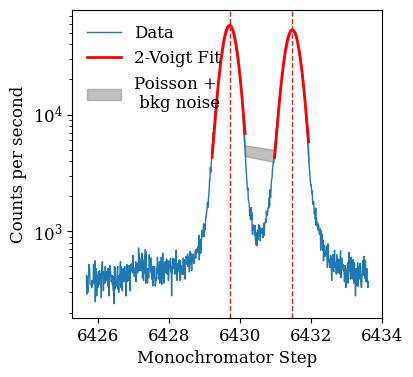

In [ ]:
# run = 2
line = 3

# path = DIR + files[run -1]
plt.figure(figsize=(4,4))
path = DIR + day_4_data[str(line)]

df = pd.read_csv(path, sep=r"\s+")
step = df["Monochromator-step"].to_numpy()
wl = cal_func(step)
cps  = df["cps"].to_numpy()

FWHM = 0.517
step_min = inv_cal_func(info[str(line)]["wl_range"][0])
step_max = inv_cal_func(info[str(line)]["wl_range"][1])
# step_min = inv_cal_func(info[str(line)]["lineD"] - FWHM*4.0)
# step_max = inv_cal_func(info[str(line)]["line"] + FWHM*4.0)


#mask = (step > step_min) & (step < step_max)

# mask st only point > 5*snr are included
mask = (step > step_min) & (step < step_max) & (cps > bkg_mean + 5.*sig_bkg)
plot_mask  = (step > step_min) & (step < step_max)
xw_plot = step[plot_mask]
yw_plot = cps[plot_mask]

print(step_min, step_max)

if len(info[str(line)]["wl_range"]) == 4:
    step_outer_min = inv_cal_func(info[str(line)]["wl_range"][0])
    step_outer_max = inv_cal_func(info[str(line)]["wl_range"][3])
    step_inner_max = inv_cal_func(info[str(line)]["wl_range"][1])
    step_inner_min = inv_cal_func(info[str(line)]["wl_range"][2])
    print("here")
    print(step_outer_min, step_inner_max, step_inner_min, step_outer_max)
    plt.axhspan(0, cps.max(), step_outer_min, step_inner_max, color='grey', alpha=0.3)
    plt.axhspan(0, cps.max(), step_inner_min, step_outer_max, color='grey', alpha=0.3)
    mask = ((step > step_outer_min) & (step < step_inner_max) ) | ((step > step_inner_min) & (step < step_outer_max))

xw = step[mask]
yw = cps[mask]
t_int = 0.1
sig_poisson = np.sqrt(yw/t_int)
#sig_bkg = np.std(yw[:50])

sig_y = np.sqrt(sig_poisson**2 + sig_bkg**2)
muH0 =  inv_cal_func(info[str(line)]["line"])
muD0 = muH0 - 1.18
AH0  = yw.max()
AD0  = yw.max()
sigma0 = 0.2
gamma0 = 0.05
C0 = 0
D0 = np.median(yw[:10])

bounds = (
    [0,      muH0-2, 0,      muH0-6, 0, 0, 0, 0, -np.inf],
    [np.inf, muH0+2, np.inf, muH0+2, 2, 2,0.1, 0.1, np.inf]
    )


p0 = [AH0, muH0, AD0, muD0, sigma0, sigma0, gamma0, C0, D0]
popt, pcov = curve_fit(two_voigts_widths, xw, yw, p0=p0, bounds=bounds, maxfev=20000, absolute_sigma=True, sigma  = sig_y )

#AH, muH, AD, muD, sigma, gamma, C, D = popt
AH, muH, AD, muD, sigma, sigma2, gamma, C, D = popt
perr = np.sqrt(np.diag(pcov))
var_muH = pcov[1,1]
var_muD = pcov[3,3]
cov_muH_muD = pcov[1,3]
cov_lH_dlam = var_muH - cov_muH_muD

# calibration part for the difference Δλ
_, C2 = pred_var([muH, muD], coeff, cov_cal)
var_cal_lambdaH = C2[0,0]
var_cal_lambdaD = C2[1,1]
covar_cal_muH_muD = C2[0,1]
var_cal = var_cal_lambdaH + var_cal_lambdaD - 2.0*covar_cal_muH_muD

# centroid part from the joint fit (indices: muH=1, muD=3)
sH = float(dp(muH))
sD = float(dp(muD))
var_cent = (sH**2)*var_muH + (sD**2)*var_muD - 2.0*sH*sD*cov_muH_muD
print("var cent:", var_cent)
print("var cal:", var_cal)

sig_cal_H = np.sqrt(var_cal_lambdaH)
print("sig cal H:", sig_cal_H)
print(sig_cal_H)
sig_cent_H = abs(sH) * np.sqrt(var_muH)
sig_lambda_H = np.hypot(sig_cal_H, sig_cent_H) # hypotenuse, add in quadrature

var_dlam = float(var_cal + var_cent)
sig_dlambda = np.sqrt(max(var_dlam, 0.0))

dlam = p(muH) - p(muD)
lambda_H = p(muH)
lambda_D = p(muD)
sig_lambda_D = np.sqrt(var_cal_lambdaD + (sD**2)*var_muD)
# get 2x2 submatrix for muH and muD
cov_mu = [[pcov[1,1], pcov[1,3]],
            [pcov[3,1], pcov[3,3]]]

print(f"Δλ = {dlam:.5f} ± {sig_dlambda:.5f} Å")
print(f"λ_H = {lambda_H :.5f} ± {sig_lambda_H:.5f} Å")

# plot fit
xf = xw
#xf = np.linspace(xw.min(), xw.max(), 500)
yf = two_voigts_widths(xf, *popt)
plt.plot(xw_plot, yw_plot, lw=1, label = "Data")

yf_fit = two_voigts_widths(step, *popt)
y_plot_fit = yf_fit.astype(float).copy()
y_plot_fit[~mask] = np.nan        # break the line where data was excluded
plt.plot(step, y_plot_fit, color='red', lw=2, label='2-Voigt Fit')


plt.fill_between(xw, yw-sig_y, yw+sig_y, color='gray', alpha=0.5, label="Poisson + \n bkg noise")

text_x = step_min + 0.1
text_y = yw.max()/1.8
# plt.text(text_x, text_y, f"Δλ = {dlam:.3f} ± {sig_dlambda:.6f} A\n",
#          bbox=dict(facecolor='white', alpha=0.8))

plt.axvline(muD + 0.015, color='C3', ls='--', lw=1)
plt.axvline(muH - 0.01, color='C3', ls='--', lw=1)

# print all fit parameters
print("\nVoigt Fit Parameters:")
print(f"mu_H = {muH:.4f} ± {perr[1]:.4f} A")
print(f"mu_D = {muD:.4f} ± {perr[3]:.4f} A")
print(f"sigma = {sigma:.4f} ± {perr[4]:.4f} A")
print(f"gamma = {gamma:.4f} ± {perr[5]:.4f} A")
print(f"FWHM H = {2.0*sigma* np.sqrt(2.0*np.log(2)) + 2.0*gamma:.4f} A")
#####
plt.legend(framealpha = 0.7, loc = "upper left", frameon = False)
plt.xlabel("Monochromator Step")
plt.ylabel(r"Counts per second")

plt.yscale("log")
results[line] = {"lambda_H": lambda_H, "dlambda": dlam,
                 "lambda_D": p(muD), "sig_lambda_D": sig_lambda_D,
                 "sig_lambda_H": sig_lambda_H, "sig_dlambda": sig_dlambda,
                 "Cov_lambdaH_dlambda": cov_lH_dlam,
                 "Cov_mu": cov_mu}

plt.savefig(f"example_Balmer_fit.png", dpi=300, bbox_inches='tight')

In [ ]:
# --- Minimal Monte Carlo for Δλ uncertainty (covers curvature etc.) ---

# 2x2 centroid covariance for (muH, muD)
Cov_m = pcov[np.ix_([1, 3], [1, 3])]

N = 10000
# Draw calibration polynomials (coeffs) and centroids (muH, muD)
A_draws = np.random.multivariate_normal(coeff, cov_cal, size=N)         # (N, deg+1)
M_draws = np.random.multivariate_normal([muH, muD], Cov_m, size=N)      # (N, 2)

# Evaluate each random polynomial at each random centroid (simple loop = simplest)
dlam_samp = np.empty(N)
lamH_samp = np.empty(N)
lamD_samp = np.empty(N)
dlam_samp = np.empty(N)
for i, Ai in enumerate(A_draws):
    p_i = np.poly1d(Ai)
    muH_i, muD_i = M_draws[i]
    dlam_samp[i] = p_i(muH_i) - p_i(muD_i)

# MC summary
dlam_mc   = float(np.mean(dlam_samp))
sd_dlam_mc = float(np.std(dlam_samp, ddof=1))

print(f"[MC] Δλ = {dlam_mc:.6f} ± {sd_dlam_mc:.6f} Å")
sig_dlambda = sd_dlam_mc
results[line]["sig_dlambda_mc"] = sig_dlambda

[MC] Δλ = 1.370940 ± 0.000492 Å


Chi2/Ndof = 586.3/183 = 3.20


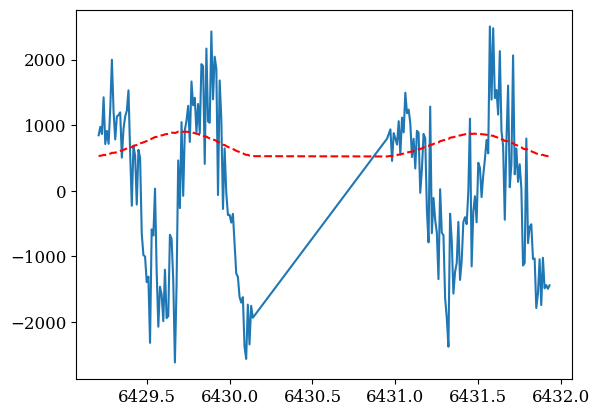

In [ ]:
# get chi2 for fit

resid = yw - two_voigts_widths(xw, *popt)


chisq = np.sum((resid/sig_y)**2)
ndof = len(yw) - len(popt)

plt.plot(xw, resid)
plt.plot(xw, sig_y, 'r--', label="Poisson errors")
print(f"Chi2/Ndof = {chisq:.1f}/{ndof} = {chisq/ndof:.2f}")

In [65]:
print(results)

{3: {'lambda_H': np.float64(6562.77159324814), 'dlambda': np.float64(1.7819766027323567), 'sig_lambda_H': np.float64(0.06870321688748823), 'sig_dlambda': np.float64(0.0005245327997984443)}, 4: {'lambda_H': np.float64(4861.975188431252), 'dlambda': np.float64(1.368792166991625), 'sig_lambda_H': np.float64(0.07038639389513088), 'sig_dlambda': np.float64(0.00010402231006988421)}, 5: {'lambda_H': np.float64(4340.692535173235), 'dlambda': np.float64(1.1838137656568506), 'sig_lambda_H': np.float64(0.04906299705133748), 'sig_dlambda': np.float64(0.00021055335256372904)}, 6: {'lambda_H': np.float64(4101.484198267094), 'dlambda': np.float64(1.1272590064272663), 'sig_lambda_H': np.float64(0.039654271049180734), 'sig_dlambda': np.float64(0.000462106449421052)}, 7: {'lambda_H': np.float64(3968.0700002859535), 'dlambda': np.float64(3.9996468154440663), 'sig_lam': np.float64(2.7415193717414275e-15), 'sd_dlambda': np.float64(2.7415193717414275e-15)}}


In [337]:
results[4]["dlambda"] = 1.345

In [325]:
from scipy.constants import m_e, m_p, physical_constants
eps = m_e / m_p  # dimensionless
md_over_mp_true = physical_constants["deuteron mass"][0] / m_p  # CODATA ratio

eps = m_e / m_p

In [ ]:
def mc_mdmp(coeff, Cov_a, muH, muD, Cov_mu, eps,  N=20000, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    # sample coeffs and centroids
    A = rng.multivariate_normal(coeff, Cov_a, size=N)
    MU  = rng.multivariate_normal([muH, muD], Cov_mu, size=N)
    m = A.shape[1] - 1
    cH = MU[:,0]; cD = MU[:,1]

    # vandermonde in descending powers, evaluated at each sampled centroid
    PH = np.vstack([cH**(m-j) for j in range(m+1)]).T
    PD = np.vstack([cD**(m-j) for j in range(m+1)]).T

    # Row-wise dot: lam = sum_j A_{ij} * P_{ij}
    lamH = np.sum(A * PH, axis=1)   # (N,)
    lamD = np.sum(A * PD, axis=1)   # (N,)
    dL   = lamH - lamD

    #mD/mp per draw
    r    = 1.0 - dL/lamH
    mdmp = eps / (r*(1+eps) - 1.0)
    mdmp_mean = float(np.mean(mdmp))
    mdmp_std  = float(np.std(mdmp, ddof=1))
    return (mdmp_mean, mdmp_std, lamH, dL, mdmp)

    # cH = MU[:,0]; cD = MU[:,1]
    # # evaluate lambda_H, lambda_D for each draw
    # # polynomial evaluators per draw:
    # lamH = np.empty(N); lamD = np.empty(N)
    # for k in range(N):
    #     lamH[k] = p(cH[k])
    #     lamD[k] = p(cD[k])
    # dL = lamH - lamD
    # mdmp = md_over_mp_from_lH_dL(lamH, dL)
    # return (float(np.mean(mdmp)), float(np.std(mdmp, ddof=1)),
    #         lamH, dL, mdmp)

md_over_mp = mc_mdmp(coeff, cov_cal, muH, muD, Cov_m, eps=eps, N=20000)
print(f"MD/MP = {md_over_mp[0]:.6f} ± {md_over_mp[1]:.6f}")
print("---------")
print(md_over_mp)


MD/MP = 2.074934 ± 0.000888
---------
(2.0749341855556436, 0.0008881563002679811, array([4861.79398471, 4861.53053153, 4861.78455228, ..., 4861.69374973,
       4861.81967774, 4861.68036323], shape=(20000,)), array([1.37080762, 1.37095244, 1.37096116, ..., 1.37059941, 1.37073451,
       1.37116226], shape=(20000,)), array([2.07466542, 2.07502187, 2.0749195 , ..., 2.07437279, 2.07453474,
       2.07529454], shape=(20000,)))


In [ ]:
def mc_mdmp_multi(coeff, Cov_a, mu_pairs, Cov_mus, eps, N=20000, rng=None):
    """
    coeff, Cov_a : calibration poly params and their covariance (shared)
    mu_pairs     : list of (muH_i, muD_i) per line, in steps
    Cov_mus     : list of 2x2 covariances for (muH_i, muD_i), per line
    eps         : m_e/m_p
    """
    import numpy as np
    rng = np.random.default_rng() if rng is None else rng
    m = len(coeff)-1

    # Draw calibration ONCE per trial (shared across all lines)
    A = rng.multivariate_normal(coeff, Cov_a, size=N)

    # For each line, draw centroids independently (no cross-line centroid corr)
    nlines = len(mu_pairs)
    MU = [rng.multivariate_normal([muH, muD], Cov_mu, size=N) for (muH,muD), Cov_mu in zip(mu_pairs, Cov_mus)]
    # Evaluate λ and Δλ for all lines, all draws
    mdmp_all = np.empty((N, nlines))
    for j in range(nlines):
        cH = MU[j][:,0]; cD = MU[j][:,1]
        PH = np.vstack([cH**(m-k) for k in range(m+1)]).T
        PD = np.vstack([cD**(m-k) for k in range(m+1)]).T
        lamH = np.sum(A*PH, axis=1)
        dL   = lamH - np.sum(A*PD, axis=1)
        r    = 1.0 - dL/lamH
        mdmp_all[:, j] = eps / (r*(1+eps) - 1.0)

    # Combine across lines per trial (choose weights once; simplest = equal weights)
    #mdmp_comb_tr = mdmp_all.mean(axis=1)            # or weighted mean with fixed weights
    # inverse weighted means
    weights = 1.0 / np.var(mdmp_all, axis=0, ddof=1)   # (nlines,)
    weights /= np.sum(weights)
    # weights = np.ones(nlines) / nlines
    mdmp_comb_tr = mdmp_all @ weights      # (N,)
    return {
        "per_line_mean": mdmp_all.mean(axis=0),
        "per_line_std":  mdmp_all.std(axis=0, ddof=1),
        "comb_mean":     float(mdmp_comb_tr.mean()),
        "comb_std":      float(mdmp_comb_tr.std(ddof=1)),
        "samples":       mdmp_comb_tr,
    }

mu_pairs = [(results[line]["lambda_H"], results[line]["lambda_H"] - results[line]["dlambda"]) for line in results]
cov_mus = [results[line]["Cov_mu"] for line in results]
eps = m_e / m_p
mdmp_all = mc_mdmp_multi(coeff, cov_cal, mu_pairs, cov_mus, eps, N=50000)
print("MD/MP per line:")
for i, line in enumerate(results):
    print(f" Line {line}: {mdmp_all['per_line_mean'][i]:.6f} ± {mdmp_all['per_line_std'][i]:.6f}")

print(f"Combined MD/MP = {mdmp_all['comb_mean']:.6f} ± {mdmp_all['comb_std']:.6f}")

mdmp = mdmp_all
mdmp_all = mdmp_all
mdmp_samples = mdmp_all["samples"]

MD/MP per line:
 Line 4: 2.029780 ± 0.000750
 Line 3: 1.961454 ± 0.001269
 Line 5: 1.955295 ± 0.001164
 Line 6: 1.967372 ± 0.002584
Combined MD/MP = 1.997301 ± 0.000693


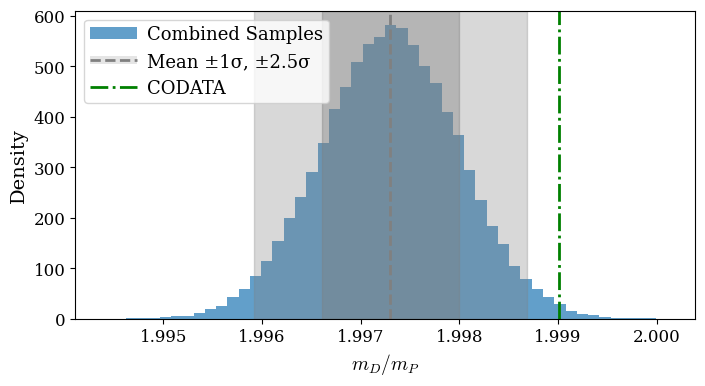

In [376]:
# make a plot with the samples
plt.figure(figsize=(8,4))
plt.hist(mdmp_samples, bins=50, density=True, alpha=0.7, label = "Combined MD/MP Samples")
plt.xlabel(r"$m_D/m_P$", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.axvline(mdmp_all["comb_mean"], color='grey', ls='--', lw=2, label="Mean")
#plot true value
plt.axvline(md_over_mp_true, color='green', ls='-.', lw=2, label="CODATA")

# plot stddev range
plt.axvspan(mdmp_all["comb_mean"] - mdmp_all["comb_std"],
            mdmp_all["comb_mean"] + mdmp_all["comb_std"],
            color='grey', alpha=0.4, label=r"$\pm 1\sigma$ range")

plt.axvspan(mdmp_all["comb_mean"] - 2*mdmp_all["comb_std"],
            mdmp_all["comb_mean"] + 2*mdmp_all["comb_std"],
            color='grey', alpha=0.3, label=r"$\pm 2\sigma$ range")

line_proxy = Line2D([0], [0], color='grey', lw=2, ls='--')
band_proxy = Rectangle((0,0),1,1, facecolor='grey', alpha=0.2, edgecolor='none')
hist_proxy = Rectangle((0,0),1,1, facecolor='C0', alpha=0.7, edgecolor='none')
handles = [
    hist_proxy,
    (line_proxy, band_proxy),
    Line2D([0], [0], color='green', lw=2, ls='-.')
]
labels = [
    "Combined Samples",
    "Mean ±1σ, ±2.5σ",
    "CODATA"
]

# # plot all lines' individual md/mp means
# for i, line in enumerate(results):
#     plt.axvline(mdmp_all["per_line_mean"][i], color='C'+str(i), ls=':', lw=1.5,
#                 label=f"Line {line} mean")
#     line_proxy = Line2D([0], [0], color='C'+str(i), lw=1.5, ls=':')
#     handles.append(line_proxy)
#     labels.append(f"Line {line} mean")

leg = plt.legend(
    handles, labels,
    handler_map={tuple: HandlerLineOverPatch()},
    frameon=True, fontsize=13,
    handlelength=2.6, handletextpad=0.6, borderpad=0.3,
    loc = "upper left"
)

#plt.legend(framealpha = 0.7, loc = "upper right", frameon = False, fontsize = 8)

#plt.xlim(1.98, 2.06)

plt.savefig(f"mdmp_combined_hist.png", dpi=300, bbox_inches='tight')

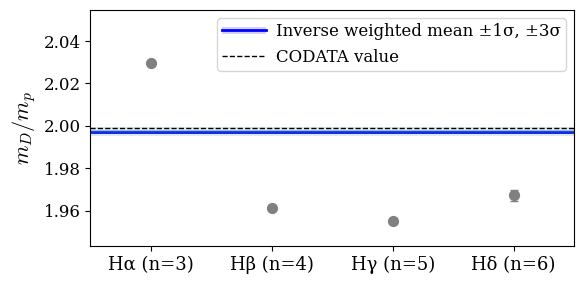

In [322]:
# Plot
c_fit = "blue"
c_data = "grey"

n_vals = np.array([3, 4, 5, 6])
mdmp = mdmp_all["per_line_mean"]
mdmp_err = mdmp_all["per_line_std"]
mdmp_comb = mdmp_all["comb_mean"]
mdmp_comb_err = mdmp_all["comb_std"]



fig, ax =  plt.subplots(figsize = (6, 3))
#plt.figure(figsize=(6.2,3.6))
x = np.arange(len(n_vals))
plt.scatter(x, mdmp, zorder=3, label="Per-line estimate", color=c_data, s=50)
plt.errorbar(x, mdmp, yerr=mdmp_err, fmt='none', capsize=3, lw=1, zorder=2, color=c_data)

plt.axhline(mdmp_comb, color=c_fit, lw=2, zorder=1)

plt.axhline(md_over_mp_true, ls='--', label='CODATA', color = 'black', lw=1)
if np.isfinite(mdmp_comb_err):
    plt.axhspan(mdmp_comb - mdmp_comb_err, mdmp_comb + mdmp_comb_err, alpha=0.35, label='Combined ±1σ')
    plt.axhspan(mdmp_comb - 3*mdmp_comb_err, mdmp_comb + 3*mdmp_comb_err, alpha=0.15, label='Combined ±2σ')

# ---------- build proxies ----------
line_proxy = Line2D([0], [0], color=c_fit, lw=2.0)
band_proxy = Rectangle((0, 0), 1, 1, facecolor=c_fit, alpha=0.18, edgecolor='none')

c_data, c_err = c_data, c_data
data_proxy = Line2D([0],[0], marker='o', color='w', markerfacecolor=c_data, markersize=8, label="Data")
err_proxy  = Line2D([0],[0], lw=1,  color=c_err)
codata_proxy = Line2D([0],[0], lw=1, ls='--', color='black')

handles = [
    #data_proxy,
    (line_proxy, band_proxy),
    codata_proxy
]
labels = [
    "Inverse weighted mean ±1σ, ±3σ",
    "CODATA value"
]

leg = ax.legend(
    handles, labels,
    handler_map={tuple: HandlerLineOverPatch()},
    frameon=True, fontsize=12,
    handlelength=2.6, handletextpad=0.6, borderpad=0.3,
    loc = "upper right"
)

lfs = 13
plt.ylabel(r"$m_D/m_p$", fontsize = lfs + 3)
# Nice xtick labels: α, β, γ, δ for n=3..6
balmer_tags = {3:"Hα", 4:"Hβ", 5:"Hγ", 6:"Hδ", 7:"Hε", 8:"Hζ", 9:"Hη"}
plt.xticks(x, [f"{balmer_tags.get(int(nv), f'n={int(nv)}')} (n={int(nv)})" for nv in n_vals], rotation=0, fontsize=lfs)

# set y limit st codata value is the centr of the y axis
r = 80
ymin = md_over_mp_true - r*mdmp_comb_err
ymax = md_over_mp_true + r*mdmp_comb_err
plt.ylim(ymin, ymax)
plt.xlim(-0.5, len(n_vals)-0.5)

plt.savefig("mdmp_mass.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [ ]:
# get chi2 to eval how consistent mass ratios are with each other
mdmp_vals = mdmp_all["per_line_mean"]
mdmp_sigs = mdmp_all["per_line_std"]
mdmp_mean = mdmp_all["comb_mean"]
chi2 = np.sum( ((mdmp_vals - mdmp_mean)/mdmp_sigs)**2 )
ndof = len(mdmp_vals) - 1
print(f"Chi2/Ndof for mass ratios: {chi2:.1f}/{ndof} = {chi2/ndof:.2f}")

Chi2/Ndof for mass ratios: 4111.5/3 = 1370.50


In [ ]:
def md_over_mp_from_lH_dL(lH, dL):
    """
    m_D/m_p from lambda_H and Delta lambda (= lambda_H - lambda_D).
    """
    r = 1.0 - dL / lH                     # r = lambda_D / lambda_H
    denom = r * (1.0 + eps) - 1.0
    return eps / denom

def md_over_mp_err_from_lH_dL(lH, sLH, dL, sDL):
    # r = 1 - dL/lH  =>  ∂r/∂lH = +dL/lH^2 ,  ∂r/∂dL = -1/lH
    var_r = (dL**2 / lH**4) * (sLH**2) + (1.0 / lH**2) * (sDL**2)
    #var_r = max(var_r, 0.0)

    r = 1.0 - dL / lH
    denom = r * (1.0 + eps) - 1.0
    dmd_dr = eps * (1.0 + eps) / (denom**2)   # magnitude
    return dmd_dr * np.sqrt(var_r)

In [76]:
print(md_over_mp_true)

1.9990075012922859


In [189]:
# Choose which Balmer n to include (ints). Example excludes n=9.
include_n = [3, 4, 5, 6]          # or: include_n = sorted(results.keys())
exclude_n = set([])               # e.g., set([9]) to exclude n=9

# Build rows safely from results
rows = []
for ni in include_n:
    if ni in exclude_n:
        continue
    if ni not in results:
        continue  # skip missing lines
    r = results[ni]
    rows.append((
        ni,
        float(r["lambda_H"]),      # λ_H in Å
        float(r["dlambda"]),       # Δλ in Å (H–D)
        float(r["sig_lambda_H"]),  # σ(λ_H)
        float(r["sig_dlambda"]) ,    # σ(Δλ)
        r["Cov_mu"]
    ))

if len(rows) == 0:
    raise RuntimeError("No valid Balmer lines to plot.")

n_vals, lamH, dlam, sig_lamH, sig_dlam, cov_mu = map(np.asarray, zip(*rows))

print(sig_lamH)
print(sig_dlam)
#mdmp     = np.array([md_over_mp_from_lH_dL(L, D) for L, D in zip(lamH, dlam)])
#mdmp_err = np.array([md_over_mp_err_from_lH_dL(L, sL, D, sD) for L, D, sL, sD in zip(lamH, dlam, sig_lamH, sig_dlam)])
#use mc function instead to get correlations right
mdmp     = np.empty_like(lamH)
mdmp_err = np.empty_like(lamH)
for i in range(len(lamH)):
    mdmp_i, mdmp_err_i, _, _, _ = mc_mdmp(
        coeff, cov_cal,
        muH=wl_to_step(lamH[i]),
        muD=wl_to_step(lamH[i] - dlam[i]),
        Cov_mu=np.array(cov_mu[i]),
        eps=eps,
        N=20000
    )
    mdmp[i] = mdmp_i
    mdmp_err[i] = mdmp_err_i

# Weighted combine (ignore NaN/zero-σ safely)
valid = np.isfinite(mdmp) & np.isfinite(mdmp_err) & (mdmp_err > 0)
if np.any(valid):
    w = 1.0 / np.square(mdmp_err[valid])
    mdmp_comb     = np.sum(w * mdmp[valid]) / np.sum(w)
    mdmp_comb_err = np.sqrt(1.0 / np.sum(w))
else:
    mdmp_comb = np.nan
    mdmp_comb_err = np.nan

# Table for slides
df = pd.DataFrame({
    "n (Balmer)": n_vals,
    r"λ_H (Å)": lamH,
    r"σ(λ_H) (Å)": sig_lamH,
    r"Δλ (Å)": dlam,
    r"σ(Δλ) (Å)": sig_dlam,
    r"m_D/m_p": mdmp,
    r"σ(m_D/m_p)": mdmp_err
}).sort_values("n (Balmer)")
print(df.to_string(index=False))

# Print combined vs known
print("\nCombined m_D/m_p = " +
      (f"{mdmp_comb:.6f} ± {mdmp_comb_err:.6f}" if np.isfinite(mdmp_comb) else "n/a"))
print(f"CODATA m_D/m_p   = {md_over_mp_true:.6f}")
if np.isfinite(mdmp_comb):
    print(f"Bias (combined − CODATA) = {mdmp_comb - md_over_mp_true:+.6f}")


[0.05532297 0.24131507 0.43436579 0.55002711]
[0.00070801 0.0005399  0.0010837  0.0014937 ]
 n (Balmer)     λ_H (Å)  σ(λ_H) (Å)   Δλ (Å)  σ(Δλ) (Å)  m_D/m_p  σ(m_D/m_p)
          3 6562.833178    0.055323 1.777956   0.000708 1.990873    0.000664
          4 4861.703068    0.241315 1.345000   0.000540 2.033565    0.000430
          5 4340.702576    0.434366 1.180960   0.001084 1.999317    0.001581
          6 4101.897856    0.550027 1.126090   0.001494 2.017582    0.002480

Combined m_D/m_p = 2.019850 ± 0.000348
CODATA m_D/m_p   = 1.999008
Bias (combined − CODATA) = +0.020842


In [236]:
# get chi2 for mD/mp values
resid_mdmp = mdmp - mdmp_comb
chisq_mdmp = np.sum((resid_mdmp/mdmp_err)**2)
ndof_mdmp = len(mdmp) - 1
print(f"Chi2/Ndof for mD/mp = {chisq_mdmp:.1f}/{ndof_mdmp} = {chisq_mdmp/ndof_mdmp:.2f}")


Chi2/Ndof for mD/mp = 3090.5/3 = 1030.17


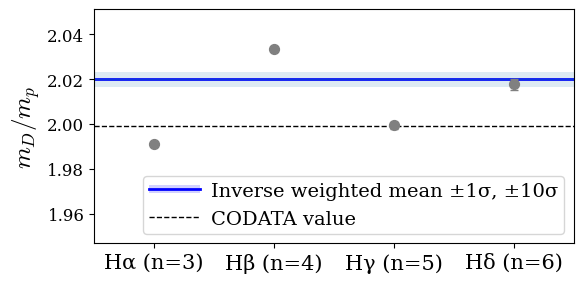

In [238]:
# Plot
c_fit = "blue"
c_data = "grey"

fig, ax =  plt.subplots(figsize = (6, 3))
#plt.figure(figsize=(6.2,3.6))
x = np.arange(len(n_vals))
plt.scatter(x, mdmp, zorder=3, label="Per-line estimate", color=c_data, s=50)
plt.errorbar(x, mdmp, yerr=mdmp_err, fmt='none', capsize=3, lw=1, zorder=2, color=c_data)

plt.axhline(mdmp_comb, color=c_fit, lw=2, zorder=1)

plt.axhline(md_over_mp_true, ls='--', label='CODATA', color = 'black', lw=1)
if np.isfinite(mdmp_comb_err):
    plt.axhspan(mdmp_comb - mdmp_comb_err, mdmp_comb + mdmp_comb_err, alpha=0.35, label='Combined ±1σ')
    plt.axhspan(mdmp_comb - 10*mdmp_comb_err, mdmp_comb + 10*mdmp_comb_err, alpha=0.15, label='Combined ±2σ')

# ---------- build proxies ----------
line_proxy = Line2D([0], [0], color=c_fit, lw=2.0)
band_proxy = Rectangle((0, 0), 1, 1, facecolor=c_fit, alpha=0.18, edgecolor='none')

c_data, c_err = c_data, c_data
data_proxy = Line2D([0],[0], marker='o', color='w', markerfacecolor=c_data, markersize=8, label="Data")
err_proxy  = Line2D([0],[0], lw=1,  color=c_err)
codata_proxy = Line2D([0],[0], lw=1, ls='--', color='black')

handles = [
    #data_proxy,
    (line_proxy, band_proxy),
    codata_proxy
]
labels = [
    "Inverse weighted mean ±1σ, ±10σ",
    "CODATA value"
]

leg = ax.legend(
    handles, labels,
    handler_map={tuple: HandlerLineOverPatch()},
    frameon=True, fontsize=14,
    handlelength=2.6, handletextpad=0.6, borderpad=0.3,
    loc = "lower right"
)

lfs = 15
plt.ylabel(r"$m_D/m_p$", fontsize = lfs + 3)
# Nice xtick labels: α, β, γ, δ for n=3..6
balmer_tags = {3:"Hα", 4:"Hβ", 5:"Hγ", 6:"Hδ", 7:"Hε", 8:"Hζ", 9:"Hη"}
plt.xticks(x, [f"{balmer_tags.get(int(nv), f'n={int(nv)}')} (n={int(nv)})" for nv in n_vals], rotation=0, fontsize=lfs)

# set y limit st codata value is the centr of the y axis
r = 150
ymin = md_over_mp_true - r*mdmp_comb_err
ymax = md_over_mp_true + r*mdmp_comb_err
plt.ylim(ymin, ymax)
plt.xlim(-0.5, len(n_vals)-0.5)

plt.savefig("mdmp_mass.png", dpi=300, bbox_inches='tight')
#plt.legend(frameon=True)
plt.tight_layout()
plt.show()


In [240]:
# evaluate consistency of results with each other; chi2
mdmp_mean = np.mean(mdmp)
resid = mdmp - mdmp_mean
chisq = np.sum((resid/mdmp_err)**2)
ndof = len(mdmp) - 1
print(f"Chi2/Ndof for mD/mp consistency = {chisq:.1f}/{ndof} = {chisq/ndof:.2f}")


Chi2/Ndof for mD/mp consistency = 3836.8/3 = 1278.93


In [ ]:
n     = np.array([3, 4, 5, 6])

# ---- Build linearized variables ----
x = 0.25 - 1.0 / (n**2)       # dimensionless
lam_m = lamH * 1e-10     # m
sig_lam_m = sig_lamH * 1e-10  # m
y = 1.0 / lam_m

sigma_y = sig_lam_m / (lam_m**2)
print(y)
print(sigma_y)

def linear_model(x, a, b):
    return a*x + b

popt, pcov = curve_fit(
    linear_model, x, y,
    sigma=sigma_y, absolute_sigma=True)

R_H, b = popt
sR_H, s_b = np.sqrt(np.diag(pcov))

print(sR_H)
# Convert to the infinite-mass Rydberg using reduced-mass correction
mu_H = (m_e * m_p) / (m_e + m_p)
R_inf = R_H * (m_e / mu_H)        # = R_H * (1 + m_e/m_p)
sR_inf = sR_H * (m_e / mu_H)

print(f"R_H     = {R_H:,.1f} ± {sR_H:,.1f} m^-1")
print(f"R_infty = {R_inf:,.1f} ± {sR_inf:,.1f} m^-1")
print(f"Intercept b = {b:.1f} ± {s_b:.1f} m^-1")


###compute chi2
y_fit = linear_model(x, *popt)
resid = y - y_fit
chisq = np.sum((resid/sigma_y)**2)
ndof = len(y) - len(popt)
from scipy.stats import chi2
pc = chi2.sf(chisq, ndof)

print(f"Chi2/Ndof = {chisq:.1f}/{ndof} = {chisq/ndof:.2f}")
print(f"p-value = {pc:.3f}")

[1523732.16393022 2056892.38100003 2303774.52128847 2437895.90838205]
[ 12.84466403 102.09573082 230.53430425 326.89961893]
1623.4338333520695
R_H     = 10,968,586.9 ± 1,623.4 m^-1
R_infty = 10,974,560.6 ± 1,624.3 m^-1
Intercept b = 317.1 ± 227.6 m^-1
Chi2/Ndof = 0.3/2 = 0.15
p-value = 0.863


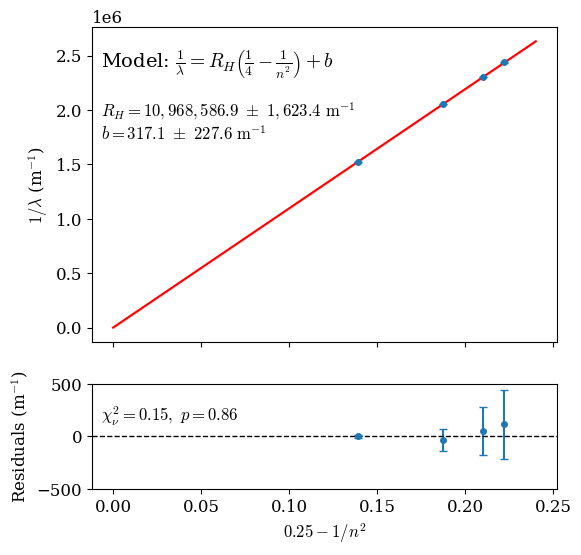

In [230]:
# plot data + fit

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)


ax1.errorbar(x, y, yerr=sigma_y, fmt='o', label="Data", capsize=3, markersize=4)
xf = np.linspace(0, 0.24, 100)
yf = linear_model(xf, *popt)
ax1.plot(xf, yf, 'r-', label="Linear fit")
ax1.set_ylabel(r"$1/\lambda$ (m$^{-1}$)")

# add error band for R_inf
sig_fit = np.sqrt( (xf * sR_inf)**2 + s_b**2 + 2*xf*pcov[0,1] )
ax1.fill_between(xf, yf - sig_fit, yf + sig_fit, color='red', alpha=0.2, label="Fit ±1σ")


# annotate text with fit results
txt1 = ( r"Model: $\frac{1}{\lambda} = R_H \left(\frac{1}{4} - \frac{1}{n^{2}}\right) + b$" "\n")
txt2 = (
    fr"$R_H = {R_H:,.1f}\ \pm\ {sR_H:,.1f}\ \mathrm{{m}}^{{-1}}$" "\n"
    fr"$b = {b:.1f}\ \pm\ {s_b:.1f}\ \mathrm{{m}}^{{-1}}$" "\n"
    #fr"$\chi^2_{{\nu-1}} = {chisq:.1f}/{ndof} = {chisq/ndof:.2f}$"
)

txt3 = (fr"$\chi^2_\nu={chisq/ndof:.2f},\ p={pc:.2f}$")

plt.text(
    0.02, 4.2, txt1, fontsize = 14,
    ha="left", va="top", transform=plt.gca().transAxes)

plt.text(
    0.02, 3.7, txt2,
    ha="left", va="top", transform=plt.gca().transAxes
    #, bbox=dict(facecolor='white', alpha=0.8)
    )

plt.text(
    0.02, 0.8, txt3,
    ha="left", va="top", transform=plt.gca().transAxes
    #, bbox=dict(facecolor='white', alpha=0.8)
    )

ax2.errorbar(x, resid, yerr=sigma_y, fmt='o', capsize=3, markersize=4)
ax2.axhline(0, color='black', ls='--', lw=1)
ax2.set_ylabel(r"Residuals (m$^{-1}$)")
ax2.set_xlabel(r"$0.25 - 1/n^2$")
ax2.set_ylim(-500, 500)


plt.savefig("Rydberg_fit.pdf", dpi=300, bbox_inches='tight')